In [1]:
# Hybrid DenseNet121 + ViT Sugarcane Disease Classification
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTFeatureExtractor
import os
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import shutil
import numpy as np 
import random
from math import floor

2025-05-25 19:17:59.472792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748200679.928778      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748200680.057208      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
def split_dataset(dataset_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Create output directories for train, val, test sets
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop through each class (directory) in the dataset
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # List all image files in the class directory
        image_files = os.listdir(class_dir)
        
        # Shuffle the images randomly
        random.shuffle(image_files)
        
        # Calculate the split indices
        total_images = len(image_files)
        train_count = floor(total_images * train_ratio)
        val_count = floor(total_images * val_ratio)
        test_count = total_images - train_count - val_count  # The rest goes to test

        # Split the images
        train_files = image_files[:train_count]
        val_files = image_files[train_count:train_count + val_count]
        test_files = image_files[train_count + val_count:]

        # Copy files to the appropriate directories
        for file in train_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(train_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in val_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(val_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

        for file in test_files:
            src = os.path.join(class_dir, file)
            dest = os.path.join(test_dir, class_name)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(src, dest)

    print("Dataset successfully split into train, validation, and test sets.")

# Usage
dataset_dir = '/kaggle/input/sugarcane-leaf-disease-dataset/Sugarcane Leaf Disease Dataset' 
output_dir = '/kaggle/working/'

split_dataset(dataset_dir, output_dir)

Dataset successfully split into train, validation, and test sets.


In [5]:
# Replace these paths with your local dataset path
data_dir = "/kaggle/working/"  # Change this
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [6]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [9]:
# Load models
from transformers import ViTModel, ViTFeatureExtractor
densenet = models.densenet121(pretrained=False)
densenet.classifier = nn.Identity()
from transformers import ViTModel, ViTFeatureExtractor
vit = ViTModel.from_pretrained("/kaggle/input/vit-model/vit model")
feature_extractor = ViTFeatureExtractor.from_pretrained("/kaggle/input/vit-model/vit model")

In [10]:
# Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, densenet, vit, num_classes):
        super(HybridModel, self).__init__()
        self.densenet = densenet
        self.vit = vit
        self.classifier = nn.Sequential(
            nn.Linear(1024 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            densenet_features = self.densenet(x)
            vit_features = self.vit(pixel_values=x).pooler_output
        combined = torch.cat((densenet_features, vit_features), dim=1)
        return self.classifier(combined)

In [11]:
num_classes = 5  # change to your number of classes
model = HybridModel(densenet, vit, num_classes).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/25
Train Loss: 1.2552 | Acc: 55.73%
Val Loss: 0.9382 | Acc: 74.80%
--------------------------------------------------
Epoch 2/25
Train Loss: 0.8707 | Acc: 72.36%
Val Loss: 0.6892 | Acc: 78.80%
--------------------------------------------------
Epoch 3/25
Train Loss: 0.7023 | Acc: 76.87%
Val Loss: 0.5673 | Acc: 82.80%
--------------------------------------------------
Epoch 4/25
Train Loss: 0.5767 | Acc: 81.49%
Val Loss: 0.4893 | Acc: 84.80%
--------------------------------------------------
Epoch 5/25
Train Loss: 0.5105 | Acc: 83.42%
Val Loss: 0.4214 | Acc: 89.60%
--------------------------------------------------
Epoch 6/25
Train Loss: 0.4504 | Acc: 86.40%
Val Loss: 0.3743 | Acc: 90.00%
--------------------------------------------------
Epoch 8/25
Train Loss: 0.3618 | Acc: 89.23%
Val Loss: 0.3043 | Acc: 91.60%
--------------------------------------------------
Epoch 9/25
Train Loss: 0.3380 | Acc: 90.22%
Val Loss: 0.2841 | Acc: 92.40%
-------------------------------------------

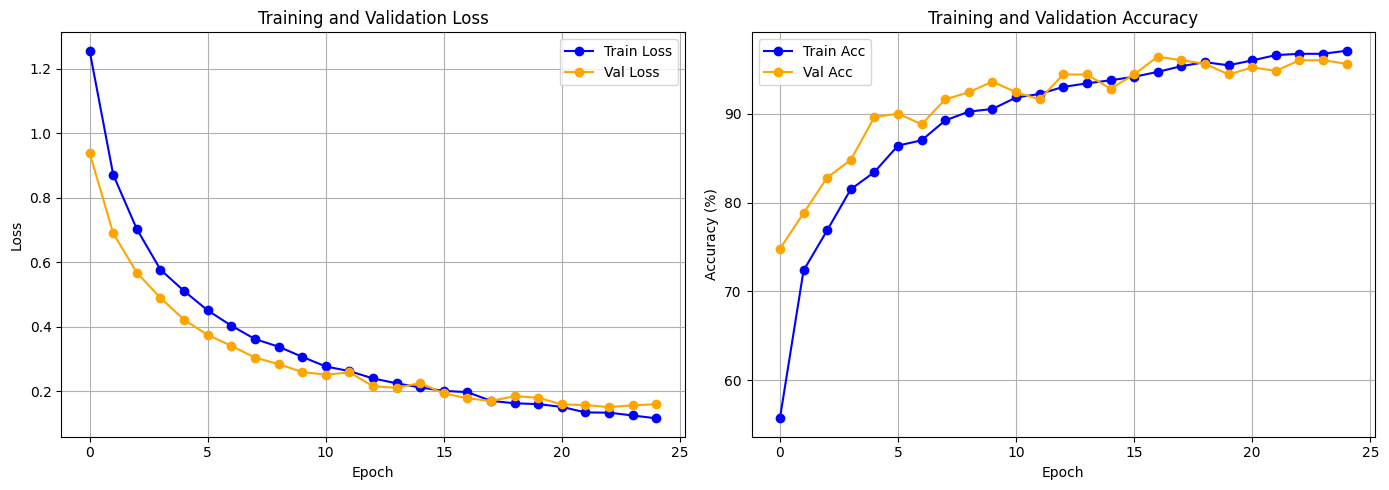

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize metric trackers
train_loss_history = []
train_acc_history = []
val_loss_history = [] 
val_acc_history = []

num_epochs = 25
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Your memory management
        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
    
    # Store training metrics
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            
            # Memory management for validation
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
    
    # Store validation metrics
    val_loss = val_loss / val_total
    val_acc = 100 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%") 
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
    print("-"*50)

# Plot learning curves
plt.figure(figsize=(14, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', marker='o', color='blue')
plt.plot(val_loss_history, label='Val Loss', marker='o', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc', marker='o', color='blue') 
plt.plot(val_acc_history, label='Val Acc', marker='o', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

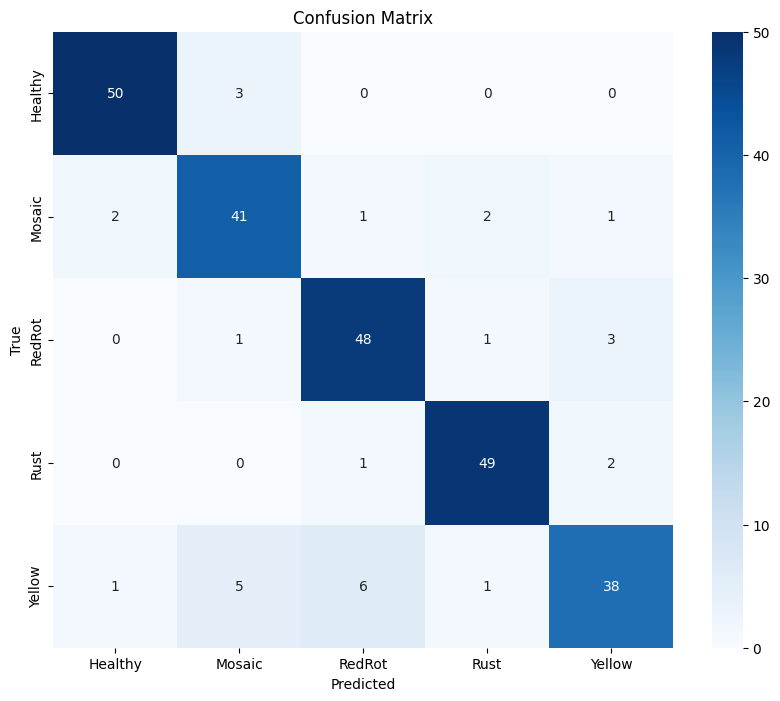


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.94      0.94        53
      Mosaic       0.82      0.87      0.85        47
      RedRot       0.86      0.91      0.88        53
        Rust       0.92      0.94      0.93        52
      Yellow       0.86      0.75      0.80        51

    accuracy                           0.88       256
   macro avg       0.88      0.88      0.88       256
weighted avg       0.88      0.88      0.88       256


Weighted F1 Score: 0.8818


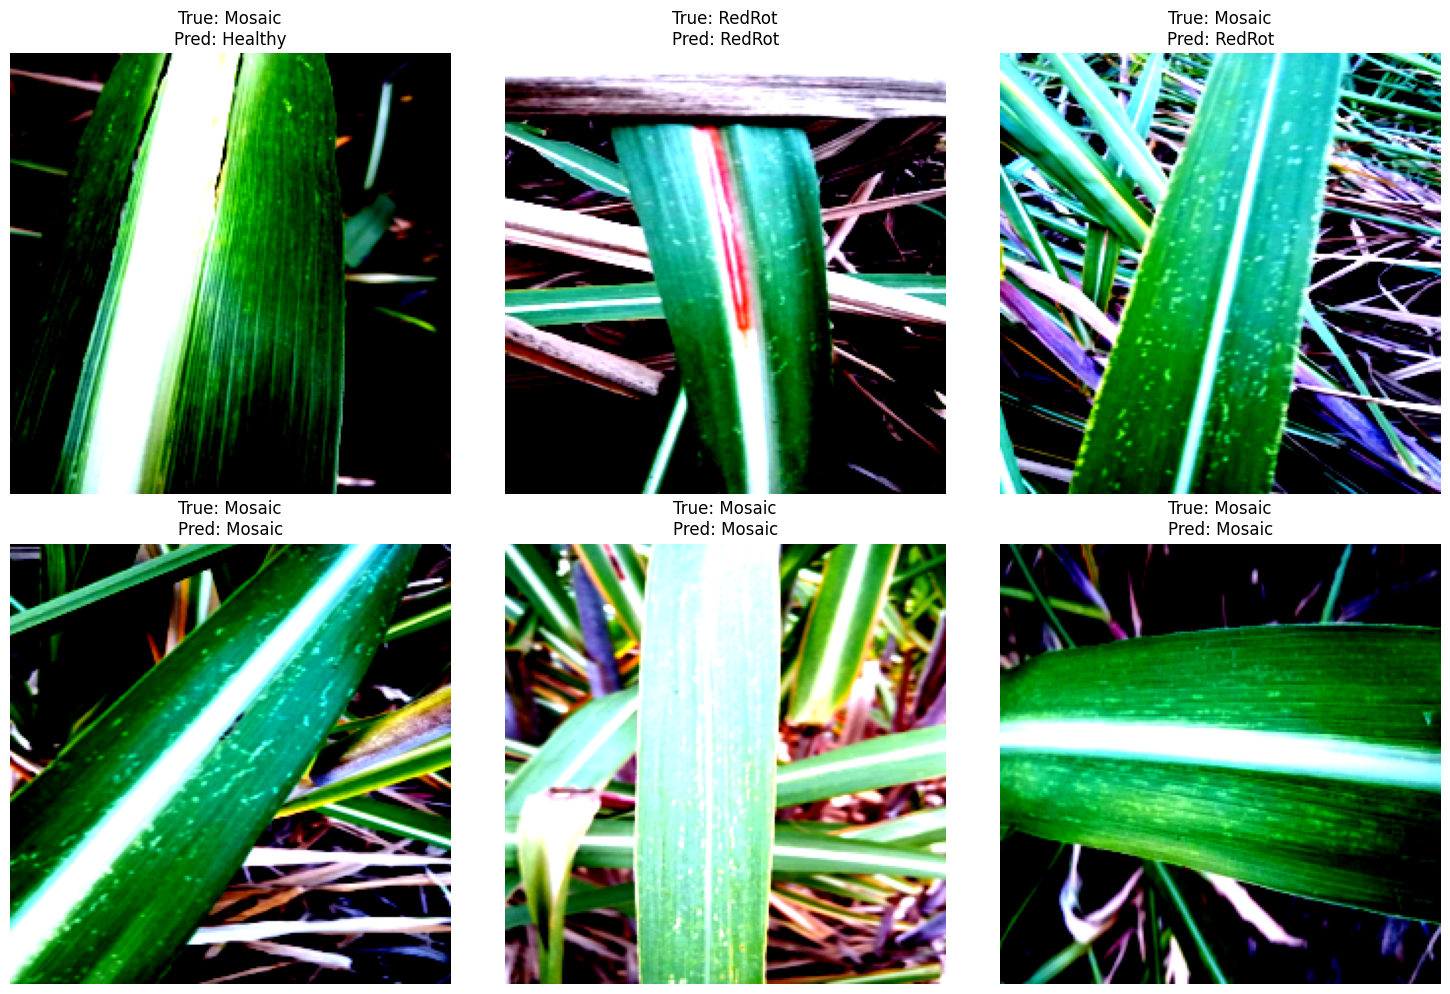

In [14]:
# 1. Save the trained model (IMPORTANT!)
torch.save(model.state_dict(), 'sugarcane_disease_model.pth')

# 2. Load the test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3. Evaluation function
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# 4. Get predictions
true_labels, pred_labels = evaluate(model, test_loader)

# 5. Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(true_labels, pred_labels, test_dataset.classes)

# 6. Classification Report (Includes F1 Score)
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=test_dataset.classes))

# 7. Calculate F1 Score
from sklearn.metrics import f1_score

f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")

# 8. Plot sample predictions
def plot_sample_predictions(dataset, model, num_samples=6):
    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    indices = np.random.choice(len(dataset), num_samples)
    
    for idx, ax in zip(indices, axes.ravel()):
        image, label = dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)
        
        ax.imshow(image.cpu().squeeze().permute(1, 2, 0))
        ax.set_title(f"True: {dataset.classes[label]}\nPred: {dataset.classes[pred.item()]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_predictions(test_dataset, model)